# Feature Engineering

In practice, data rarely comes in a tidy ``[n_samples, n_features]`` format. One of the important steps in using machine learning in practice is **feature engineering**: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build feature matrix.

We will cover a few common examples of feature engineering tasks: features for representing **categorical data**, features for representing **text**, and features for representing **images**.
Additionally, we will discuss **derived features** for increasing model complexity and **imputation** of missing data.
Often this process is known as **vectorization**, as it involves converting arbitrary data into well-behaved vectors.

## Categorical Features

One common type of non-numerical data is **categorical** data.
For example, there are some data on housing prices, and along with numerical features like "price" and "rooms", we also have "neighborhood" information.
For example,

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

It is tempting to encode this data with a straightforward numerical mapping:

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach.
Thus such a mapping would imply, for example, that **Queen Anne < Fremont < Wallingford**, or that **Wallingford - Queen Anne = Fremont**, which does not make sense.

In this case, one proven technique is to use **one-hot encoding**, which creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [2]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [3]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can greatly increase the size of dataset. However, because the encoded data contains mostly zeros, a **sparse** output can be a very efficient solution (**only non-zero values and their indices are stored**):

In [4]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by **word counts**: take each piece of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [7]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on, using Scikit-Learn's ``CountVectorizer``:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears; it is easier to check if we convert this to a ``DataFrame`` with labeled columns:

In [9]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


However, the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is [**term frequency-inverse document frequency (TF–IDF)**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log (Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

The syntax for computing these features is similar:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Image Features

Another need is to suitably encode **images** for machine learning analysis.
**The common approach is simply using the pixel values.**
But depending on the application, we also need to preprocess the images, for example, extracting image patches of smaller size from the original images.

A comprehensive summary of feature extraction techniques for images is beyond the scope, but you can find excellent implementations of many of the standard approaches in the [Scikit-Image project](http://scikit-image.org).

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features, such as constructing **polynomial features** from  input data.
We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input.

For example, this data clearly cannot be well described by a straight line:

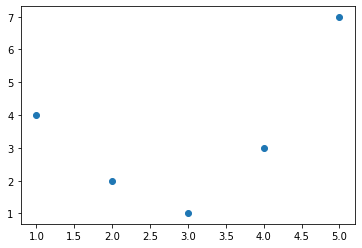

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

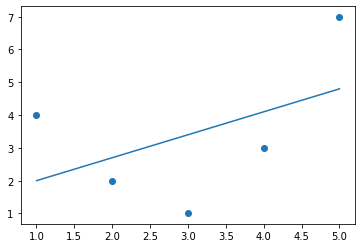

In [14]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model.
For example, we can add polynomial features to the data this way:

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$.
Computing a linear regression on this expanded input gives a much closer fit to our data:

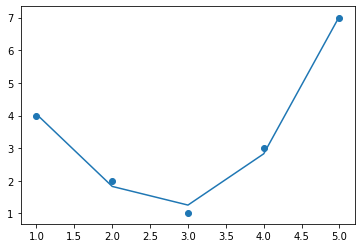

In [17]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods, such as **kernel methods** combined with Support Vector Machines.

## Imputation of Missing Data

Another common need in feature engineering is handling of missing data.
We discussed the handling of missing data in ``DataFrame``s in handling missing data, and saw that often the ``NaN`` value is used to mark missing values.
For example:

In [18]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as **imputation** of missing values, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion model to impute by assuming the data matrix is low-rank).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the ``SimpleImputer`` class:

In [23]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a ``LinearRegression`` classifier:

In [24]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## Feature Pipelines

We can establish a processing pipeline:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a linear regression

To streamline this type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [25]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

This pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [26]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


All the steps of the model are applied automatically.